# Mollow triplets 2

In [91]:
from functools import partial
import pdb

import pickle
import numpy as np
from scipy.optimize import minimize
from scipy.fftpack import fft, fftshift, fftfreq
from scipy.integrate import quad
from scipy.special import factorial, sinc
import matplotlib.pyplot as plt

import pysme.integrate as integ
import pysme.hierarchy as hier
import pysme.sparse_system_builder as ssb
import qinfo as qi
from qinfo import supops

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
# define Qubit operators
sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
sy = np.array([[0, -1.j], [1.j, 0]], dtype=np.complex)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
Id = np.eye(2, dtype=np.complex)
sp = (sx + 1.j * sy) / 2
sm = (sx - 1.j * sy) / 2
zero = np.zeros((2, 2), dtype=np.complex)

In [5]:
plt.style.use('../paper.mplstyle')

A coherent drive adds a Hamiltonian term.
\begin{align}
    d\rho&=dt[\beta^*L-\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    &=-idt[i\beta^*L-i\beta L^\dagger,\rho]+dt\mathcal{D}[L]\rho \\
    H_{\text{eff}}&=i\beta^*L-i\beta L^\dagger
\end{align}
For $L=\sqrt{\gamma}\sigma_-$, the Rabi frequency is $\Omega=2\sqrt{\gamma}|\beta|$.

(Carmichæl notates the Rabi frequency as $2\Omega$, so in his notation $\Omega=\sqrt{\gamma}|\beta|$.

In [6]:
def Heff_fn(beta, L):
    return 1.j*np.conj(beta)*L - 1.j*beta*L.conj().T

Try to reproduce plots from my thesis.

In [7]:
def rect(x, a, b):
    return np.where(x < a, 0, np.where(x < b, 1, 0))

def xi_rect(t, a, b):
    return rect(t, a, b)/np.sqrt(b - a)

In [8]:
gamma = 1
beta = 16.j
r = np.log(2)
mu = 0
T = 4
xi_fn = partial(xi_rect, a=0, b=T)
Omega = 2*np.sqrt(gamma)*np.abs(beta)

In [9]:
Omega

In [10]:
rho0 = (Id - sz) / 2
S = Id
L = np.sqrt(gamma)*sm
H = zero

Parameters indicating how precisely we compute the correlators.

In [11]:
tau_final = 2**8
tau_samples = 2**12
taus = np.linspace(0, tau_final, tau_samples)

How long we evolve for to get steady-state.

In [12]:
times_ss = np.linspace(0, 32, 2**14)

Derived quantities useful for figuring out the scale of the frequency-domain steps.

In [13]:
frequencies = fftshift(fftfreq(taus.shape[0], np.diff(taus)[0]))
omegas = 2*np.pi*frequencies
d_omega = np.diff(omegas)[0]
Rabi_offset = 2*np.abs(beta) // d_omega

Functions for calculating the necessary correlation functions.

In [14]:
def calc_white_auto_corr(L, beta, r, mu, times_ss, taus, solve_ivp_kwargs=None):
    N = np.sinh(r)**2
    M_sq = -np.exp(2.j * mu) * np.sinh(r) * np.cosh(r)
    integrator = integ.UncondGaussIntegrator(L, M_sq, N, Heff_fn(beta, L))
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)

    return rho_ss, Expt_t_taus - sp_ss * sm_ss

def calc_hier_auto_corr(xi_fn, L, r, mu, beta, m_max, taus, rho_ss, t, t0=0, timesteps=2**10,
                        solve_ivp_kwargs=None):
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, L, Heff_fn(beta, L), r, mu)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    sp_ss_t = soln_t.get_expectations(sp, vac_rho(m_max), idx_slice=np.s_[-1], hermitian=False)
    rho_ss_t = soln_t.get_hierarchy_density_matrices(np.s_[-1])
    L_t_t = rho_ss_t @ np.kron(sp, Id_field)
    L_t_taus = integrator.integrate_hier_init_cond(L_t_t, taus + t,
                                                   solve_ivp_kwargs=solve_ivp_kwargs)
    Expt_t_taus = L_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    soln_t_taus = integrator.integrate_hier_init_cond(rho_ss_t, taus + t,
                                                      solve_ivp_kwargs=solve_ivp_kwargs)
    sm_ss_t_taus = soln_t_taus.get_expectations(sm, vac_rho(m_max), hermitian=False)
    # Subtract off a bunch of stuff that gets rid of the delta
    return (Expt_t_taus - sp_ss_t * sm_ss - sp_ss * sm_ss_t_taus + sp_ss * sm_ss,
            sp_ss, sm_ss, sp_ss_t, sm_ss_t_taus)

def calc_hier_auto_corr_fock(xi_fn, L, r, mu, beta, m_max, taus, rho_ss, t, t0=0, timesteps=2**10,
                             solve_ivp_kwargs=None):
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)
    Id_field = np.eye(m_max + 1, dtype=np.complex)
    factory = hier.HierarchyIntegratorFactory(2, m_max)
    integrator = factory.make_uncond_integrator(xi_fn, Id, L, Heff_fn(beta, L), 0, 0)
    times = np.linspace(t0, t, timesteps)
    soln_t = integrator.integrate(rho_ss, times)
    sp_ss_t = soln_t.get_expectations(sp, sqz_rho(r, mu, m_max), idx_slice=np.s_[-1], hermitian=False)
    rho_ss_t = soln_t.get_hierarchy_density_matrices(np.s_[-1])
    L_t_t = rho_ss_t @ np.kron(sp, Id_field)
    L_t_taus = integrator.integrate_hier_init_cond(L_t_t, taus + t,
                                                   solve_ivp_kwargs=solve_ivp_kwargs)
    Expt_t_taus = L_t_taus.get_expectations(sm, sqz_rho(r, mu, m_max), hermitian=False)
    soln_t_taus = integrator.integrate_hier_init_cond(rho_ss_t, taus + t,
                                                      solve_ivp_kwargs=solve_ivp_kwargs)
    sm_ss_t_taus = soln_t_taus.get_expectations(sm, sqz_rho(r, mu, m_max), hermitian=False)
    # Subtract off a bunch of stuff that gets rid of the delta
    return (Expt_t_taus - sp_ss_t * sm_ss - sp_ss * sm_ss_t_taus + sp_ss * sm_ss,
            sp_ss, sm_ss, sp_ss_t, sm_ss_t_taus)

In [15]:
def lam_mu(gamma_c, eps):
    lam = gamma_c + eps
    mu = gamma_c - eps
    return lam, mu

def N_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               - 1/((omega - omega_A)**2 + lam**2))
    
def mod_M_degen_PA(omega, omega_A, lam, mu):
    return (lam**2 - mu**2)/4*(1/((omega - omega_A)**2 + mu**2)
                               + 1/((omega - omega_A)**2 + lam**2))

def deltas_degen_PA(gamma_c, Omega, lam, mu):
    delta_mu = gamma_c*Omega*(lam**2 - mu**2)/(4*mu*(Omega**2 + mu**2))
    delta_lam = gamma_c*Omega*(lam**2 - mu**2)/(4*lam*(Omega**2 + mu**2))
    return delta_mu, delta_lam

def F_G(delta_mu, delta_lam, Phi):
    F_A = -(1j/4)*(delta_mu*(1 + np.cos(Phi))
                   - delta_lam*(1 - np.cos(Phi)))
    G_A = -(1/4)*(delta_mu + delta_lam)*np.sin(Phi)
    return F_A, G_A

def get_degen_PA_params(Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s):
    lam, mu = lam_mu(gamma_c, eps)
    N_A = N_degen_PA(omega_A, omega_A, lam, mu)
    N_Om = N_degen_PA(omega_A + Omega, omega_A, lam, mu)
    mod_M_A = mod_M_degen_PA(omega_A, omega_A, lam, mu)
    mod_M_Om = mod_M_degen_PA(omega_A + Omega, omega_A, lam, mu)
    M_A = np.exp(2j*phi_s)*mod_M_A
    M_Om = np.exp(2j*phi_s)*mod_M_Om
    Delta_AL = omega_A - omega_L
    Phi = 2*phi_L - phi_s
    delta_mu, delta_lam = deltas_degen_PA(gamma_c, Omega, lam, mu)
    F_A, G_A = F_G(delta_mu, delta_lam, Phi)
    return N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A

def calc_quasi_markoff_degen_PA_auto_corr(
        gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus, solve_ivp_kwargs=None):
    N_A, N_Om, M_A, M_Om, Delta_AL, F_A, G_A = get_degen_PA_params(
        Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s)
    integrator = integ.QuasiMarkoff2LvlIntegrator(
        gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

In [16]:
def get_fluorescence_spectrum(auto_corr):
    fluorescence = fftshift(fft(auto_corr))
    return fluorescence

In [17]:
def gen_save_load_data(data_gen_method, fname, overwrite=False):
    '''Get the data returned by the generating method, running the method only if the data isn't already available.

    If the given filename exists, load and return the data from that file. Otherwise generate the data using the
    supplied method and save and return it.

    Useful for notebooks you imagine running multiple times, but where some of the data is expensive to generate
    and you want to save it to disk to be reloaded for future sessions.

    '''
    try:
        with open(fname, 'xb' if not overwrite else 'wb') as f:
            data = data_gen_method()
            pickle.dump(data, f)
    except FileExistsError:
        print('Data already exist.')
        with open(fname, 'rb') as f:
            data = pickle.load(f)
    return data

In [18]:
def gen_Expt_t_taus_wavepacket(
        xi_fn, L, r, mu, beta, m_max, taus, rho_ss_coh, t_final, solve_ivp_kwargs=None):
    '''Generate autocorrelation function for squeezed hierarchy

    Parameters
    ----------
    xi_fn : callable (float -> complex)
        Function returning the wavepacket amplitude at the evaluated time
    L : np.array
        Lindblad operator
    r : float
        Squeezing strength
    mu : float
        Squeezing angle
    beta : complex
        Drive amplitude
    m_max : int
        Hierarchy truncation level
    taus : np.array
        Times at which to evaluate the autocorrelation function
    rho_ss_coh : np.array
        The steady-state density matrix for a coherently driven atom
    t_final : float
        The fiducial time t to compute the auto correlation fn wrt: <sp(t)sm(t+tau)>
    solve_ivp_kwargs : dict
        Keyword arguments for the ``solve_ivp`` call made when integrating the hierarchy

    '''
    return calc_hier_auto_corr(xi_fn, L, r, mu, beta, m_max,
                               taus, rho_ss_coh, t=t_final,
                               solve_ivp_kwargs=solve_ivp_kwargs)

In [19]:
def rho_from_ket(ket):
    return np.outer(ket, ket.conj())

def vac_rho(n):
    ket = np.zeros(n + 1, dtype=np.complex)
    ket[0] = 1
    return rho_from_ket(ket)

def make_squeezed_state_vec(r, mu, N, normalized=True):
    r'''Make a truncated squeezed-state vector.

    The squeezed-state vector is :math:`S(r,\mu)|0\rangle`. The truncated
    vector is renormalized by default.

    Parameters
    ----------
    N: positive integer
        The dimension of the truncated Hilbert space, basis {0, ..., N-1}
    r: real number
        Squeezing amplitude
    mu: real number
        Squeezing phase
    normalized: boolean
        Whether or not the truncated vector is renormalized

    Returns
    -------
    numpy.array
        Squeezed-state vector in the truncated Hilbert space, represented in the
        number basis

    '''
    ket = np.zeros(N, dtype=np.complex)
    for n in range(N//2):
        ket[2*n] = (1 / np.sqrt(np.cosh(r))) * ((-0.5 * np.exp(2.j * mu) * np.tanh(r))**n /
                                                factorial(n)) * np.sqrt(factorial(2 * n))
    return ket / np.linalg.norm(ket) if normalized else ket

def sqz_rho(r, mu, n):
    return rho_from_ket(make_squeezed_state_vec(r, mu, n + 1))

In [20]:
rho_ss_coh, delta_Expt_t_taus_coh = calc_white_auto_corr(L, beta, 0, 0, times_ss, taus,
                                                         solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})

In [21]:
fluor_spec = get_fluorescence_spectrum(delta_Expt_t_taus_coh)

Text(0.5, 0, '$(\\omega-\\Omega)/\\Gamma$')

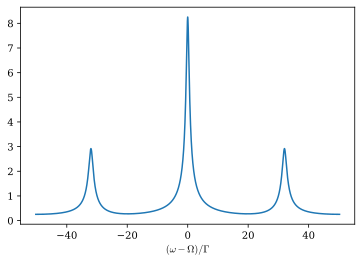

In [22]:
fig, ax = plt.subplots()
ax.plot(omegas, np.abs(fluor_spec))
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')

In [23]:
m_max = 12
t_final = 0.5
Expt_t_taus_wavepacket, _, _, _, _ = gen_save_load_data(partial(gen_Expt_t_taus_wavepacket, xi_fn=xi_fn, L=L, r=r,
                                                                mu=mu, beta=beta, m_max=m_max, taus=taus,
                                                                rho_ss_coh=rho_ss_coh, t_final=t_final,
                                                                solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9}),
                                                        '2020-06-25/Expt_t_taus_wavepacket.pickle')

Data already exist.


In [24]:
Expt_t_taus_wavepacket

array([ 4.99320613e-01+0.j,  1.51640406e-01+0.j,  8.04227137e-02+0.j, ...,
       -1.32136987e-08+0.j, -4.13006597e-09+0.j,  1.75379286e-08+0.j])

In [25]:
fluor_spec_wavepacket = get_fluorescence_spectrum(Expt_t_taus_wavepacket)

Text(0.5, 0, '$(\\omega-\\Omega)/\\Gamma$')

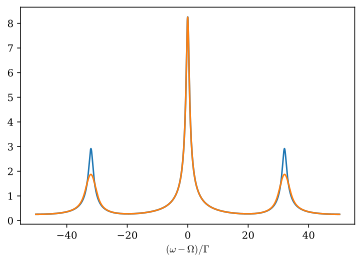

In [26]:
fig, ax = plt.subplots()
ax.plot(omegas, np.abs(fluor_spec))
ax.plot(omegas, np.abs(fluor_spec_wavepacket))
ax.set_xlabel(r'$(\omega-\Omega)/\Gamma$')

For a rectangular wavepacket
\begin{align}
    \xi_t
    &=
    \begin{cases}
    1/\sqrt{T} & 0\leq t\leq T
    \\
    0 & \text{otherwise}
    \end{cases}
\end{align}
we have
\begin{align}
    \langle b_\omega^\dagger b_{\omega^\prime}\rangle_{\gamma,\xi}
    &=
    \frac{4s^2}{T}e^{i(\omega^\prime-\omega)T/2}
    \frac{\sin(\omega^\prime T/2)\sin(\omega T/2)}{\omega\omega^\prime}
    \\
    &=
    s^2Te^{i(\omega^\prime-\omega)T/2}
    \frac{\sin(\omega^\prime T/2)}{\omega^\prime T/2}\frac{\sin(\omega T/2)}{\omega T/2}
    \\
    &=
    s^2Te^{i(\omega^\prime-\omega)T/2}\operatorname{sinc}(\omega^\prime T/2\pi)
    \operatorname{sinc}(\omega T/2\pi)
    \\
    \operatorname{sinc}(x)
    &=
    \frac{\sin(\pi x)}{\pi x}
\end{align}

In [28]:
def rect_correlator(omega, omega_p, s, T):
    return (s**2*T*np.exp(1.j*(omega_p - omega)*T/2)
            *sinc(omega_p*T/(2*np.pi))*sinc(omega*T/(2*np.pi)))

In [29]:
Omega, Omega_p = np.mgrid[-2*np.pi:2*np.pi:129j,-2*np.pi:2*np.pi:129j]

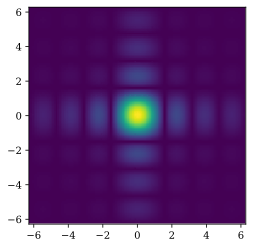

In [36]:
correlations = rect_correlator(Omega, Omega_p, np.sinh(np.log(2)), 4)
fig, ax = plt.subplots()
ax.pcolormesh(Omega, Omega_p, np.abs(correlations), rasterized=True)
ax.set_aspect('equal')

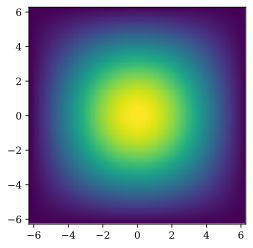

In [38]:
correlations = rect_correlator(Omega, Omega_p, np.sinh(np.log(2)), 1)
fig, ax = plt.subplots()
ax.pcolormesh(Omega, Omega_p, np.abs(correlations), rasterized=True)
ax.set_aspect('equal')

In [50]:
class QuasiMarkoff2LvlIntegrator(integ.UncondLindbladIntegrator):
    def __init__(self, gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A):
        dim = 2
        basis = ssb.SparseBasis(dim)
        self.basis = basis
        sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
        sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex)
        sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
        sp = (sx + 1j*sy)/2
        sm = (sx - 1j*sy)/2
        # Eqn 16 and 17 in [YB96]
        Sm = sm*np.exp(-1j*phi_L)
        Sp = sp*np.exp(1j*phi_L)
        Y = 1j*sz@(Sp + Sm)
        sz_vec = self.basis.vectorize(sz)
        Sm_vec = self.basis.vectorize(Sm)
        Sp_vec = self.basis.vectorize(Sp)
        Y_vec = self.basis.vectorize(Y)
        H_vec = ((Omega/2 + 1j*F_A)*(Sp_vec + Sm_vec)
                 + (Delta_AL/2)*sz_vec + G_A*Y_vec)

        self.Q = -gamma/4*(
                (1 + N_A)*(basis.make_double_comm_matrix(Sm_vec, 1)
                           - 2*basis.make_diff_op_matrix(Sm_vec))
                + N_A*(basis.make_double_comm_matrix(Sp_vec, 1)
                       - 2*basis.make_diff_op_matrix(Sp_vec))
                + (1 + N_Om)*(-basis.make_double_comm_matrix(Sm_vec, 1)
                            - 2*basis.make_diff_op_matrix(Sm_vec))
                + N_Om*(-basis.make_double_comm_matrix(Sp_vec, 1)
                        - 2*basis.make_diff_op_matrix(Sp_vec))
                - 2*basis.make_double_comm_matrix(Sm_vec, M_A*np.exp(-2j*phi_L))
                + 2*basis.make_real_comm_matrix(M_A*np.exp(-2j*phi_L)*Sp_vec,
                                                Sp_vec)
                + 2*basis.make_real_comm_matrix(np.conjugate(M_A)*np.exp(2j*phi_L)
                                                *Sm_vec, Sm_vec)
                - 2*basis.make_double_comm_matrix(Sm_vec,
                                                  M_Om*np.exp(-2j*phi_L))
                - 2*basis.make_real_comm_matrix(M_Om*np.exp(-2j*phi_L)*Sp_vec,
                                                Sp_vec)
                - 2*basis.make_real_comm_matrix(np.conjugate(M_Om)*np.exp(2j*phi_L)
                                                *Sm_vec, Sm_vec))
        self.Q += basis.make_hamil_comm_matrix(H_vec)
        self.Q += -2*basis.make_real_sand_matrix(F_A*(Sp_vec - Sm_vec), sz_vec)
        self.Q += -2*basis.make_real_sand_matrix(G_A*(Sp_vec + Sm_vec), sz_vec)

In [55]:
def get_quasi_markoff_ss_slow(gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A, times_ss):
    integrator = QuasiMarkoff2LvlIntegrator(
        gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    return rho_ss

In [75]:
def get_quasi_markoff_ss(gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A):
    phi_s = 0.5*np.angle(M_A) # Assumes the angle is independent of frequency
    Phi = 2*phi_L - phi_s
    gamma_Omega = gamma*(N_Om + np.abs(M_Om)*np.cos(Phi))
    gamma_0 = gamma*(N_A - np.abs(M_A)*np.cos(Phi) + 1/2)
    A = np.array([[-gamma_Omega, gamma*np.abs(M_Om)*np.sin(Phi), -2*G_A],
                  [gamma*np.abs(M_A)*np.sin(Phi), -gamma_0, 0.5*Omega + 2.j*F_A],
                  [0, -2*Omega, -gamma_0 - gamma_Omega]])
    bloch_vec_ss = np.linalg.inv(A)@np.array([0, 0, gamma])

    sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
    sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex)
    sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
    rho_ss = 0.5*(np.eye(2) + bloch_vec_ss[0]*sx + bloch_vec_ss[1]*sy + bloch_vec_ss[2]*sz)
    return rho_ss

In [93]:
def integrator_to_lind_proc_tensor(integrator, t=0):
    if isinstance(integrator.basis, ssb.SparseBasis):
        op_basis = qi.OperatorBasis(integrator.basis.basis.todense())
    else:
        op_basis = qi.OperatorBasis(integrator.basis.basis)
    lind_proc_mat = integrator.jac(t, rho_vec=None)
    lind_process = lambda rho: supops.act_proc_mat(rho, lind_proc_mat, op_basis)
    lind_proc_tensor = supops.process_to_proc_tensor(lind_process, op_basis.vec_dim)
    return lind_proc_tensor

def get_lind_degen_choi_mat(lind_proc_tensor):
    dim = lind_proc_tensor.shape[0]
    Id_proc_tensor = supops.get_identity_proc_tensor(dim)
    Id_choi_mat = supops.proc_tensor_to_choi_mat(Id_proc_tensor)
    Id_choi_mat_degen_proj = (np.eye(Id_choi_mat.shape[0], dtype=Id_choi_mat.dtype)
                              - qi.rho_from_ket(np.linalg.eigh(Id_choi_mat)[1][:,-1]))
    lind_choi_mat = supops.proc_tensor_to_choi_mat(lind_proc_tensor)
    lind_degen_choi_mat = Id_choi_mat_degen_proj @ lind_choi_mat @ Id_choi_mat_degen_proj
    return lind_degen_choi_mat

In [129]:
gamma = 1
r_A = np.log(2)
r_Om = np.log(2)/2
phi_s = 0
Nth_A = 0
Nth_Om = 0
N_A = (2*Nth_A + 1)*np.sinh(r_A)**2 + Nth_A
N_Om = (2*Nth_Om + 1)*np.sinh(r_Om)**2 + Nth_Om
M_A = -(2*Nth_A + 1)*np.exp(2j*phi_s)*np.sinh(r_A)*np.cosh(r_A)
M_Om = -(2*Nth_Om + 1)*np.exp(2j*phi_s)*np.sinh(r_Om)*np.cosh(r_Om)
F_A = 0.1j
G_A = .05
Delta_AL = 0
Omega = 8
phi_L = 0
integrator = QuasiMarkoff2LvlIntegrator(
                gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)

In [130]:
lind_proc_tensor = integrator_to_lind_proc_tensor(integrator)

In [131]:
degen_choi_mat = get_lind_degen_choi_mat(lind_proc_tensor)

In [132]:
np.round(degen_choi_mat, 4)

array([[-0.   +0.j , -0.05 -0.1j, -0.05 +0.1j,  0.   +0.j ],
       [-0.05 +0.1j,  1.625+0.j ,  0.875+0.j ,  0.05 -0.1j],
       [-0.05 -0.1j,  0.875+0.j ,  0.625+0.j ,  0.05 +0.1j],
       [-0.   +0.j ,  0.05 +0.1j,  0.05 -0.1j,  0.   +0.j ]])

In [133]:
np.linalg.eigvalsh(degen_choi_mat)

array([-1.48401169e-01, -8.87579035e-18,  2.59968716e-01,  2.13843245e+00])

Looks like we get negativity fairly easily as a result of arbitrary `F_A` values.

In [79]:
get_quasi_markoff_ss_slow(1., 1., 1., 1, 1, 1., 1., 0., 0., 0., np.linspace(0, 2**6, 2**12))

array([[ 0.37837838+0.j        , -0.05405405-0.13513513j],
       [-0.05405405+0.13513513j,  0.62162162+0.j        ]])

In [80]:
get_quasi_markoff_ss(1., 1., 1., 1, 1, 1., 1., 0., 0., 0.)

array([[0.38888889+0.j        , 0.        +0.11111111j],
       [0.        -0.11111111j, 0.61111111+0.j        ]])

I seem to have not quite got this part right...

In [70]:
def calc_quasi_markoff_auto_corr(
        gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A, times_ss, taus, solve_ivp_kwargs=None):
    integrator = QuasiMarkoff2LvlIntegrator(
        gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A)
    soln_ss = integrator.integrate(Id/2, times_ss)

    rho_ss = soln_ss.get_density_matrices(np.s_[-1])
    sp_ss = np.trace(sp @ rho_ss)
    sm_ss = np.trace(sm @ rho_ss)

    L_0_taus = integrator.integrate_non_herm(rho_ss @ sp, taus, solve_ivp_kwargs=solve_ivp_kwargs)

    Expt_t_taus = L_0_taus.get_expectations(sm, hermitian=False)
    return rho_ss, Expt_t_taus - sp_ss * sm_ss

In [73]:
def get_quasi_fluors(
        T, gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A, times_ss, taus, solve_ivp_kwargs=None):
    _, Expt_t_taus = calc_quasi_markoff_auto_corr(gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A, times_ss, taus, solve_ivp_kwargs)
    fluors = get_fluorescences([Expt_t_taus], T)[1]
    return fluors

In [72]:
def get_quasi_cost_fn(target_fluor, T, gamma, beta, omega_A, omega_L, times_ss, taus, solve_ivp_kwargs=None):
    Omega = 2*np.abs(beta)
    phi_L = np.angle(beta)
    def calculate_cost(x):
        gamma_c, eps, phi_s = x
        quasi_fluor = get_quasi_fluors(T, gamma, Omega, omega_A, omega_L, gamma_c, eps, phi_L, phi_s, times_ss, taus)[0]
        return np.sum((quasi_fluor - target_fluor)**2)
    return calculate_cost

Could try and make things faster by precomputing some stuff that doesn't change when tweaking parameters.

In [ ]:
class QuasiMarkoff2LvlIntegratorFactory(UncondLindbladIntegrator):
        def __init__(self, gamma, N_A, N_Om, M_A, M_Om, Delta_AL, Omega, phi_L, F_A, G_A):
        dim = 2
        basis = ssb.SparseBasis(dim)
        self.basis = basis
        sx = np.array([[0, 1], [1, 0]], dtype=np.complex)
        sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex)
        sz = np.array([[1, 0], [0, -1]], dtype=np.complex)
        sp = (sx + 1j*sy)/2
        sm = (sx - 1j*sy)/2
        # Eqn 16 and 17 in [YB96]
        Sm = sm*np.exp(-1j*phi_L)
        Sp = sp*np.exp(1j*phi_L)
        Y = 1j*sz@(Sp + Sm)
        sz_vec = self.basis.vectorize(sz)
        Sm_vec = self.basis.vectorize(Sm)
        Sp_vec = self.basis.vectorize(Sp)
        Y_vec = self.basis.vectorize(Y)
        H_vec = ((Omega/2 + 1j*F_A)*(Sp_vec + Sm_vec)
                 + (Delta_AL/2)*sz_vec + G_A*Y_vec)

        self.N_A_1_op = (basis.make_double_comm_matrix(Sm_vec, 1)
                         - 2*basis.make_diff_op_matrix(Sm_vec))
        self.N_A_op = (basis.make_double_comm_matrix(Sp_vec, 1)
                       - 2*basis.make_diff_op_matrix(Sp_vec))
        self.N_Om_1_op = (-basis.make_double_comm_matrix(Sm_vec, 1)
                          - 2*basis.make_diff_op_matrix(Sm_vec))
        self.N_Om_op = (-basis.make_double_comm_matrix(Sp_vec, 1)
                        - 2*basis.make_diff_op_matrix(Sp_vec))

        self.Q = -gamma/4*(
                (1 + N_A)*self.N_A_1_op
                + N_A*self.N_A_op
                + (1 + N_Om)*self.N_Om_1_op
                + N_Om*self.N_Om_op
                - 2*basis.make_double_comm_matrix(Sm_vec, M_A*np.exp(-2j*phi_L))
                + 2*basis.make_real_comm_matrix(M_A*np.exp(-2j*phi_L)*Sp_vec,
                                                Sp_vec)
                + 2*basis.make_real_comm_matrix(M_A.conj()*np.exp(2j*phi_L)
                                                *Sm_vec, Sm_vec)
                - 2*basis.make_double_comm_matrix(Sm_vec,
                                                  M_Om*np.exp(-2j*phi_L))
                - 2*basis.make_real_comm_matrix(M_Om*np.exp(-2j*phi_L)*Sp_vec,
                                                Sp_vec)
                - 2*basis.make_real_comm_matrix(M_Om.conj()*np.exp(2j*phi_L)
                                                *Sm_vec, Sm_vec))
        self.Q += basis.make_hamil_comm_matrix(H_vec)
        self.Q += -2*basis.make_real_sand_matrix(F_A*(Sp_vec - Sm_vec), sz_vec)
        self.Q += -2*basis.make_real_sand_matrix(G_A*(Sp_vec + Sm_vec), sz_vec)